In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

In [248]:
df = pd.read_csv("./stations_cleaned_sample.csv")
originalColumns = df.columns.tolist()
df.shape

(1611, 21)

In [249]:
df.sample(10)

,station_code,monitoring_location,state_name,temp_min,temp_max,do_min,do_max,ph_min,ph_max,conductivity_min,...,bod_min,bod_max,nitrate_min,nitrate_max,fecal_coliform_min,fecal_coliform_max,total_coliform_min,total_coliform_max,fecal_streptococci_min,fecal_streptococci_max
982,2099,"RIVER NARMADA AT LALPUR, JABALPUR",MADHYA PRADESH,21.0,23.4,7.2,7.8,7.3,7.9,230.0,...,1.20,1.60,0.16,0.80,2.0,2.0,31.0,49.0,NaN,NaN
347,30030,"RIVER YAMUNA AT ASGARPUR VILLAGE,(YAMUNA GHAT)U.P",UTTAR PRADESH,0.3,5.4,7.4,7.7,517.0,1878.0,14.0,...,0.33,2.66,7800.00,14000000.00,23000.0,21000000.0,680.0,2400000.0,NaN,NaN
771,2892,KHA RU ADJOINING MUNICIPAL COUNCIL SWM SITE NA...,NaN,17.5,28.9,6.2,7.4,6.5,8.3,88.0,...,1.40,1.90,0.30,3.30,NaN,NaN,NaN,NaN,NaN,NaN
1134,3903,RIVER KUSHABHADRA AT BHINGARPUR,ODISHA,19.0,32.0,5.1,9.1,7.1,7.6,180.0,...,1.20,1.70,0.32,0.78,330.0,54000.0,1700.0,160000.0,NaN,NaN
844,4306,RIVER WAHKHLEK KHLEK AT SAITSOHPEN MEGHALAYA,NaN,14.0,18.0,7.2,8.5,6.9,7.6,81.0,...,1.10,1.60,0.32,5.64,2.0,4.0,23.0,49.0,2.0,2.0
618,4085,"RIVER JUMAR AT BIT MESRA, RANCHI",JHARKHAND,9.0,24.0,3.8,4.9,6.5,6.6,2.1,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,1470,"RIVER GANGA AT GARDEN REACH, KOLKATA, WEST BENGAL",WEST BENGAL,20.0,36.0,5.0,7.8,6.9,8.0,243.0,...,2.00,3.90,0.33,1.84,33000.0,94000.0,70000.0,170000.0,210.0,580.0
840,4132,"RIVER VANTAWNG WATER FALL, THENZAWL",SERCHHIP DIST. MIZORAM,14.0,27.0,5.1,7.2,6.5,7.1,30.0,...,1.00,1.50,0.02,1.43,NaN,NaN,NaN,NaN,NaN,NaN
677,4727,RIVER MECHI AT NEHALJOTE,WEST BENGAL,20.0,30.0,5.3,8.0,6.8,7.9,55.0,...,1.00,2.20,0.30,0.54,1300.0,7000.0,2100.0,28000.0,17.0,350.0
45,4448,RIVER SUTLEJ BEFORE CONFLUENCES WITH RIVER TIDONG,HIMACHAL PRADESH,7.5,11.5,9.0,9.3,7.6,8.4,118.0,...,1.00,1.00,0.32,1.40,7.0,33.0,17.0,350.0,2.0,2.0


In [250]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [251]:
df.columns

Index(['station_code', 'monitoring_location', 'state_name', 'temp_min',
       'temp_max', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min',
       'conductivity_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max',
       'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min',
       'total_coliform_max', 'fecal_streptococci_min',
       'fecal_streptococci_max'],
      dtype='object')

In [252]:
turb_cols = [c for c in df.columns if "turbid" in c or c.endswith("ntu") or c == "turbidity"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [253]:
df.drop_duplicates(inplace=True)

In [254]:
df.isna().sum()

station_code                0
monitoring_location         6
state_name                124
temp_min                    7
temp_max                    8
do_min                      8
do_max                      8
ph_min                      8
ph_max                      8
conductivity_min            8
conductivity_max            8
bod_min                     8
bod_max                     8
nitrate_min                56
nitrate_max                56
fecal_coliform_min        184
fecal_coliform_max        185
total_coliform_min        224
total_coliform_max        224
fecal_streptococci_min    766
fecal_streptococci_max    767
dtype: int64

In [255]:
summary = {
    "rows": len(df),
    "cols": len(df.columns),
    "original_columns": originalColumns,
    "normalized_columns": df.columns.tolist(),
    "candidate_turbidity_columns": turb_cols,
    "numeric_columns_count": len(numeric_cols)
}

In [256]:
schema_report = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "nulls": [df[c].isna().sum() for c in df.columns],
    "unique": [df[c].nunique(dropna=True) for c in df.columns]
})
schema_report

,column,dtype,non_null,nulls,unique
0,station_code,int64,1605,0,1604
1,monitoring_location,object,1599,6,1598
2,state_name,object,1481,124,116
3,temp_min,float64,1598,7,149
4,temp_max,float64,1597,8,164
5,do_min,float64,1597,8,101
6,do_max,float64,1597,8,115
7,ph_min,float64,1597,8,77
8,ph_max,float64,1597,8,78
9,conductivity_min,float64,1597,8,569


In [257]:
df[pd.isna(df['temp_max'])]

,station_code,monitoring_location,state_name,temp_min,temp_max,do_min,do_max,ph_min,ph_max,conductivity_min,...,bod_min,bod_max,nitrate_min,nitrate_max,fecal_coliform_min,fecal_coliform_max,total_coliform_min,total_coliform_max,fecal_streptococci_min,fecal_streptococci_max
0,1986,mg/L mg/L Ml 100 mL,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796,4121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798,3736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,4118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,3717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807,2052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,1631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1592,4743,RIVER SUBARNAREKHA U/S HCL GHATSHILA,E.S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
df = df[pd.notna(df['temp_max'])]

In [259]:
df.isna().sum()

station_code                0
monitoring_location         0
state_name                117
temp_min                    0
temp_max                    0
do_min                      0
do_max                      0
ph_min                      0
ph_max                      0
conductivity_min            0
conductivity_max            0
bod_min                     0
bod_max                     0
nitrate_min                48
nitrate_max                48
fecal_coliform_min        176
fecal_coliform_max        177
total_coliform_min        216
total_coliform_max        216
fecal_streptococci_min    758
fecal_streptococci_max    759
dtype: int64

In [260]:
missing = df[pd.isna(df['fecal_coliform_min'])]

In [261]:
for c in ['nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']:
    df[c+"missing"] = df[c].isna().astype(int)
    df[c].fillna(df[c].median(), inplace=True)

/tmp/ipykernel_74802/2476419197.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipykernel_74802/2476419197.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [262]:
df.drop(columns=["fecal_streptococci_min","fecal_streptococci_max"], inplace=True)

In [263]:
df["state_name"].fillna("Unknown", inplace=True)

/tmp/ipykernel_74802/1866281950.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["state_name"].fillna("Unknown", inplace=True)


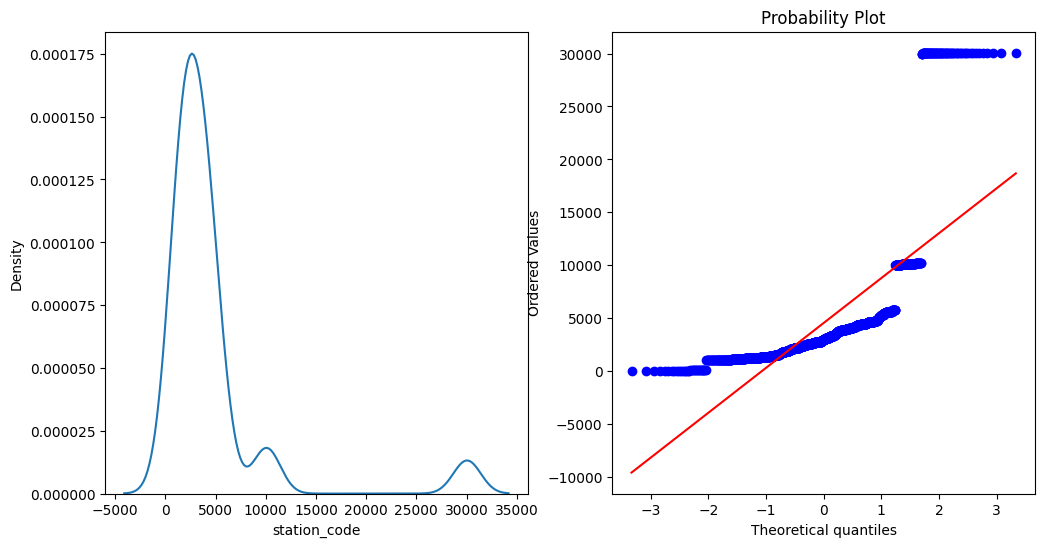

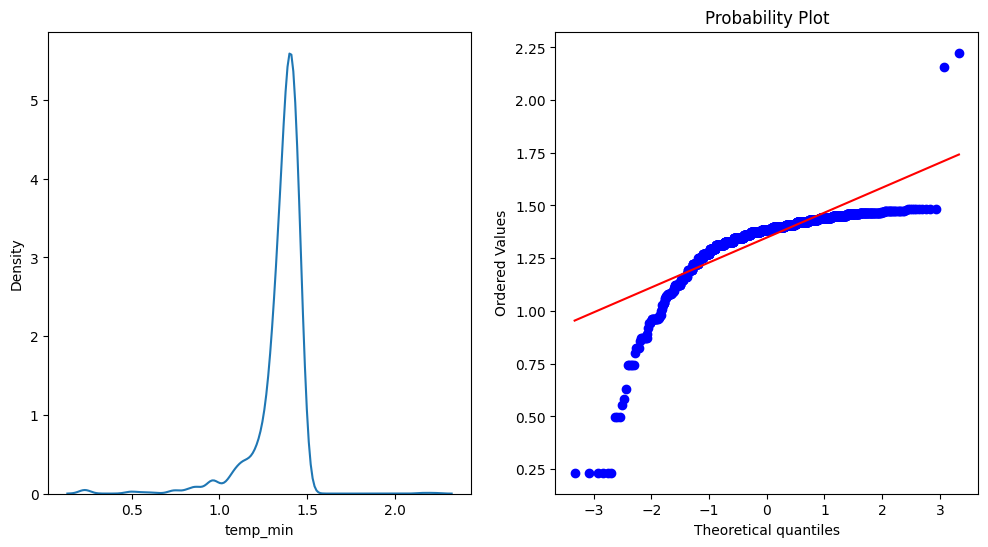

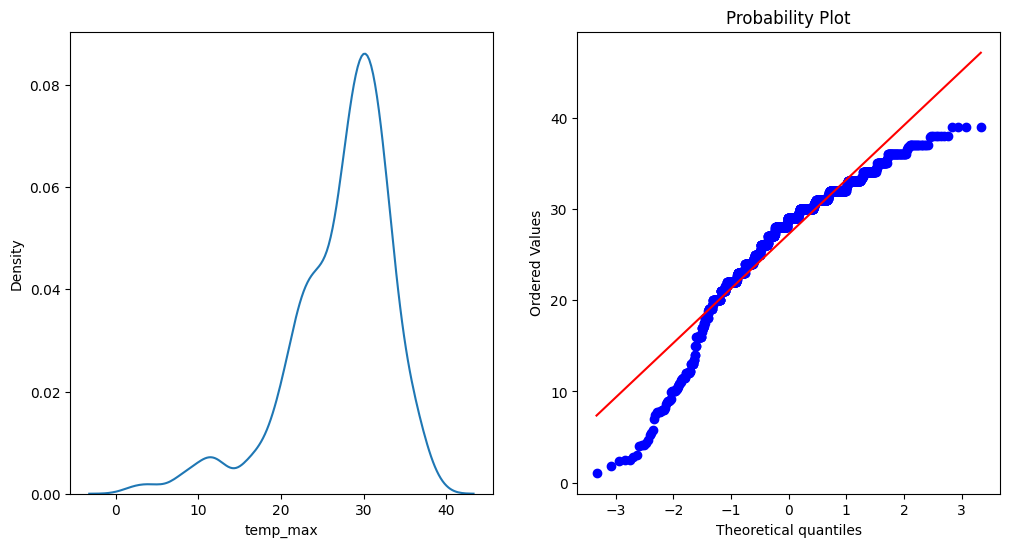

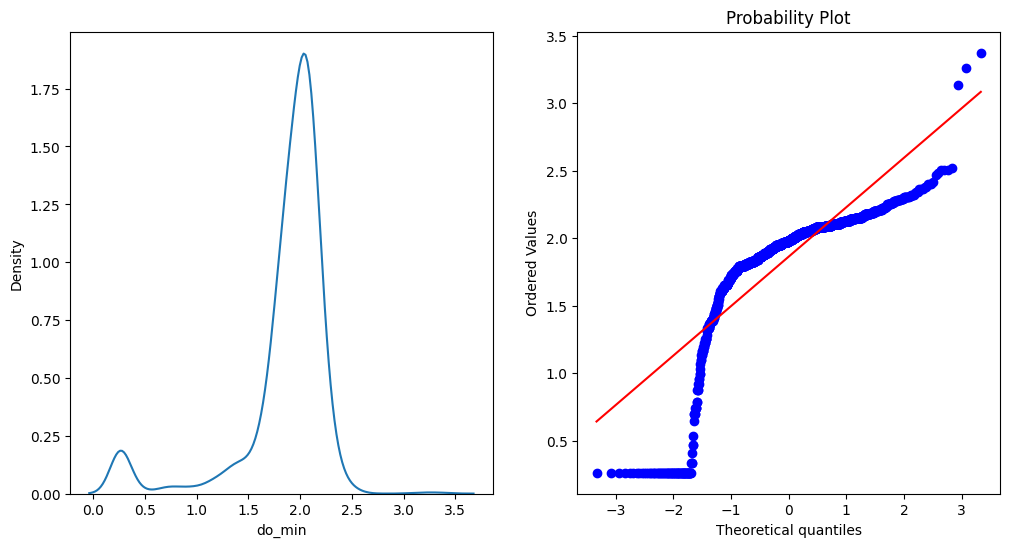

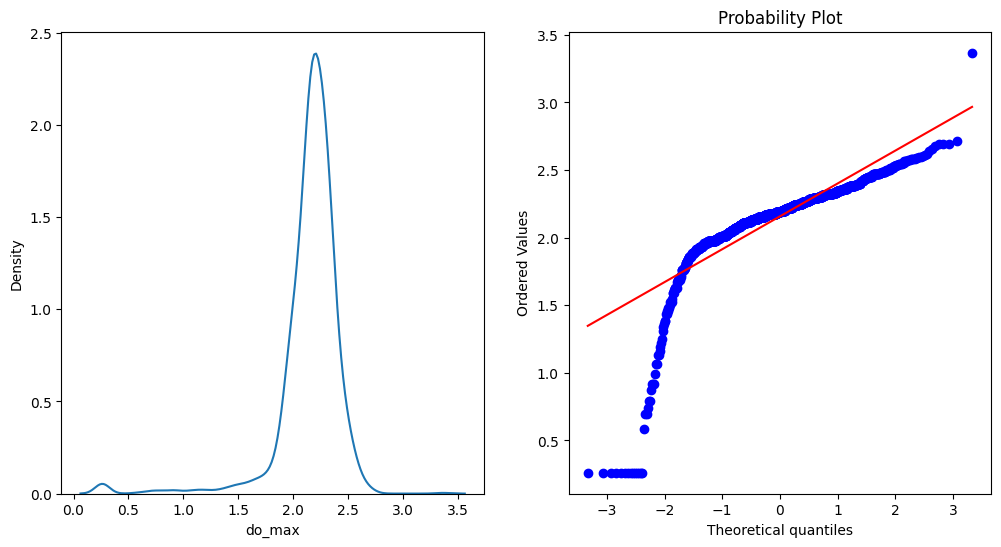

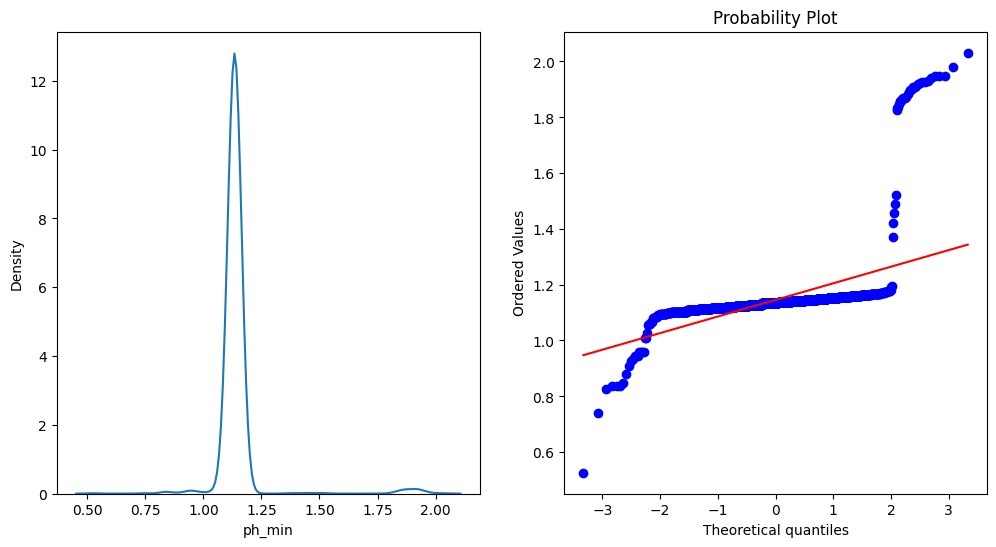

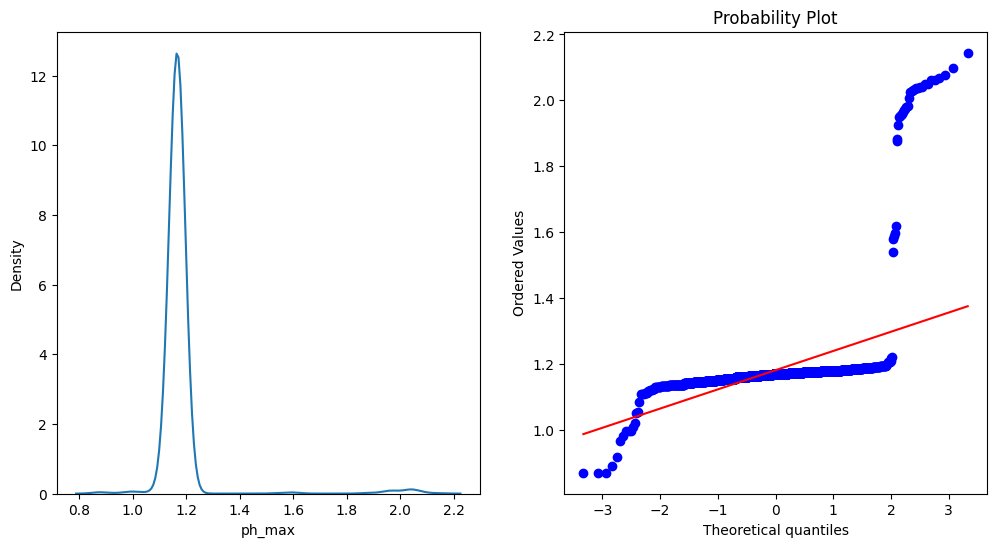

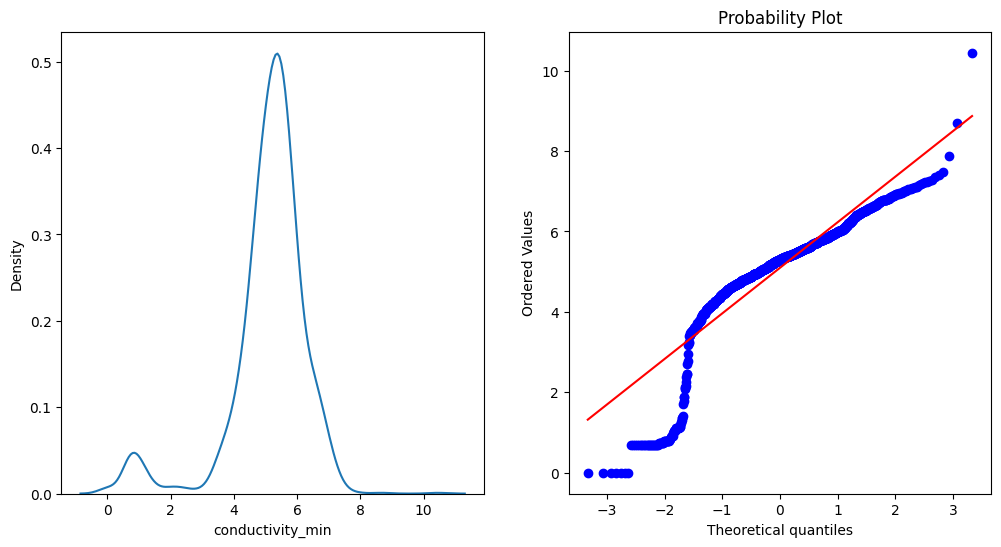

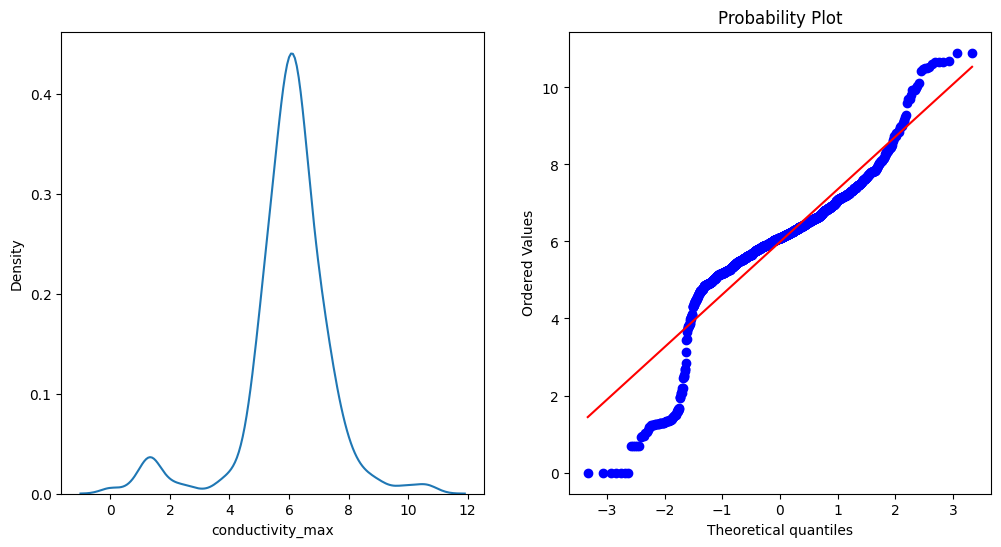

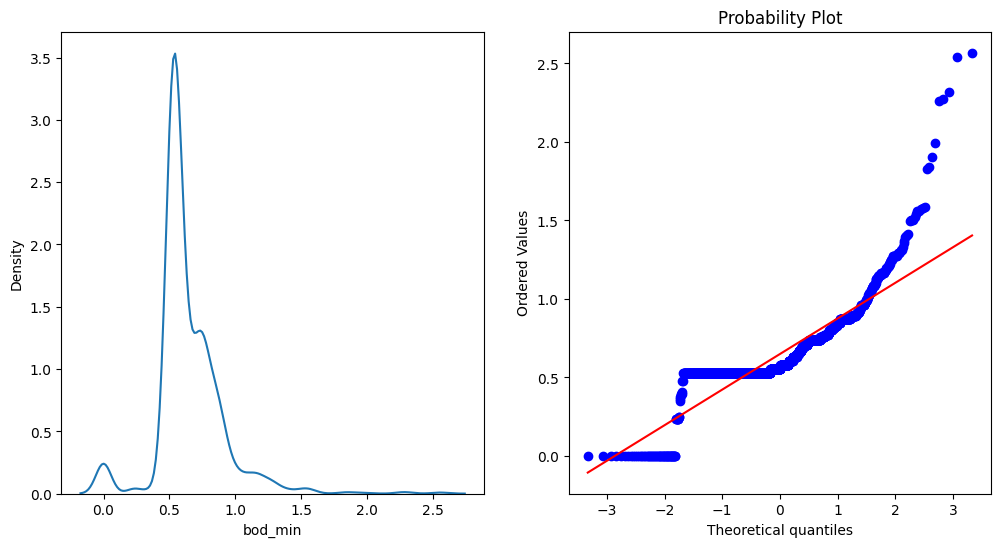

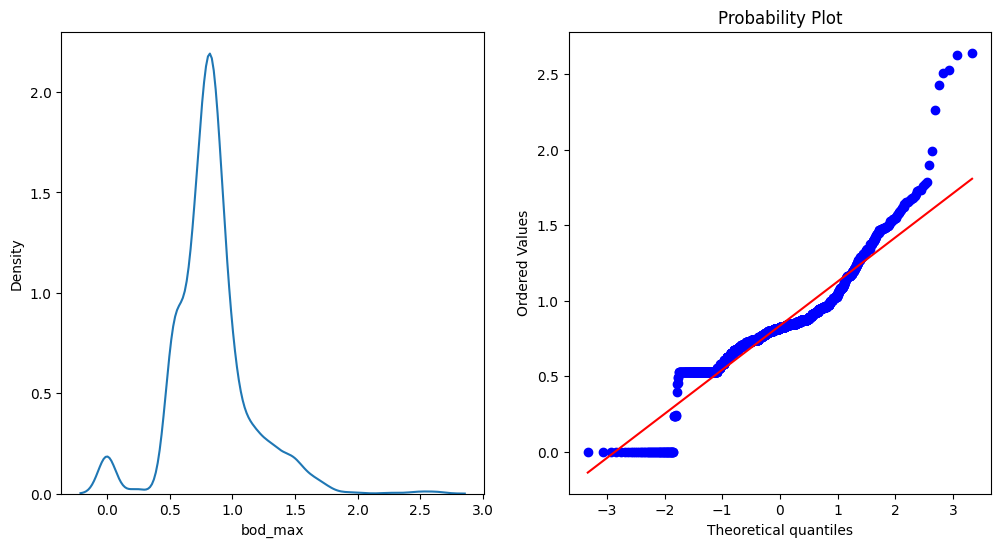

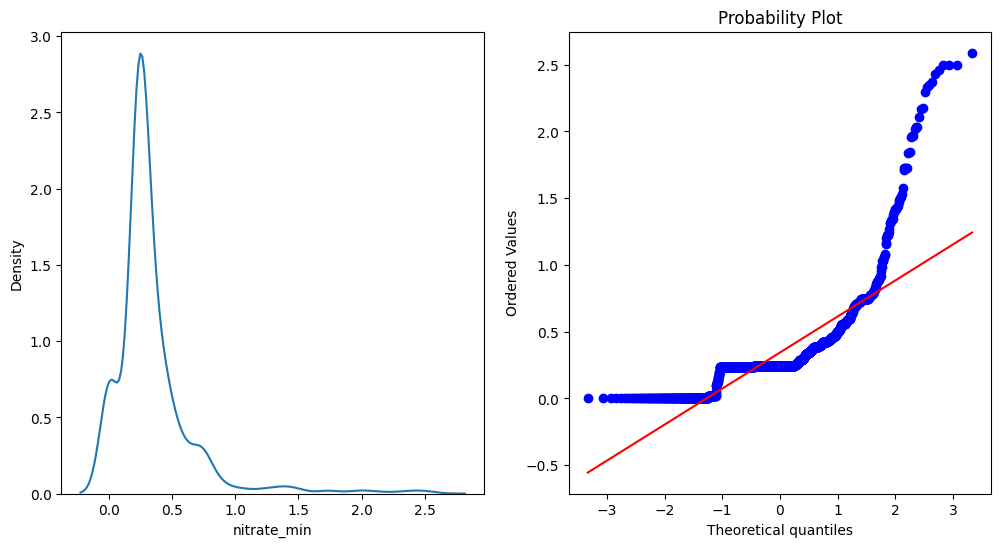

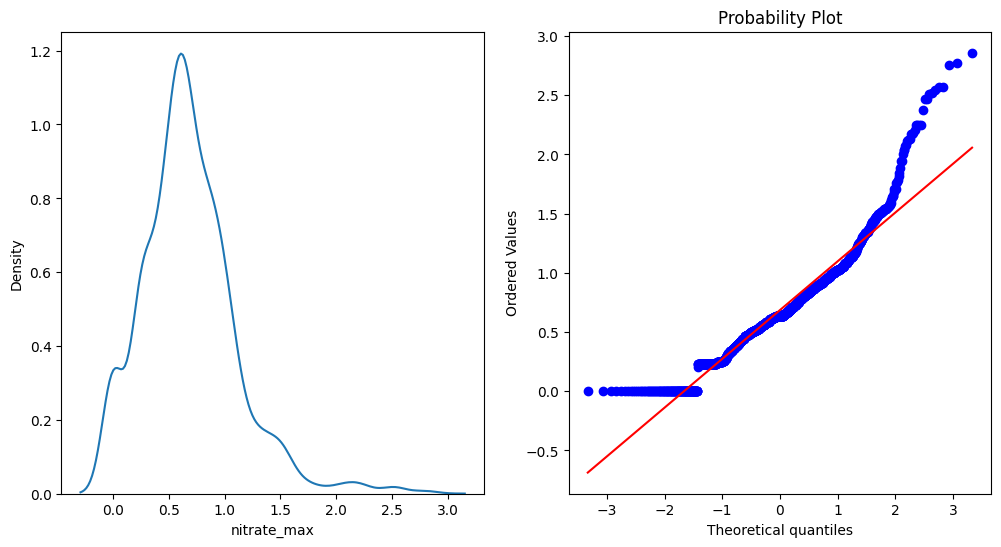

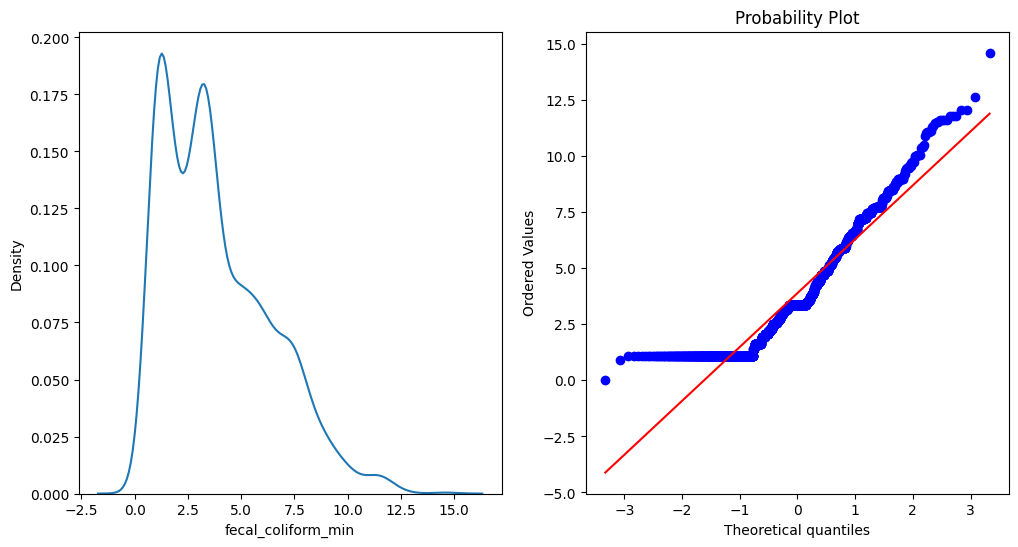

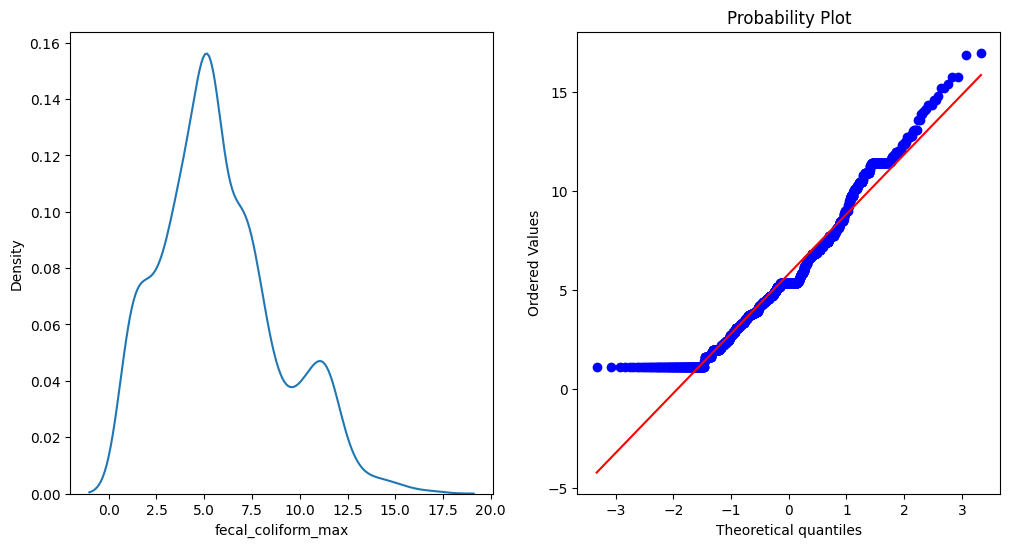

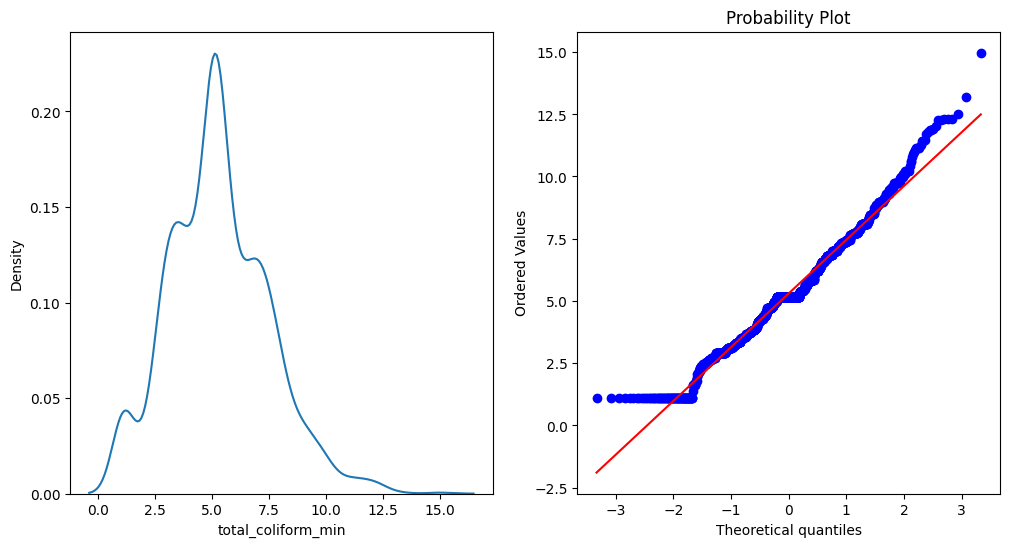

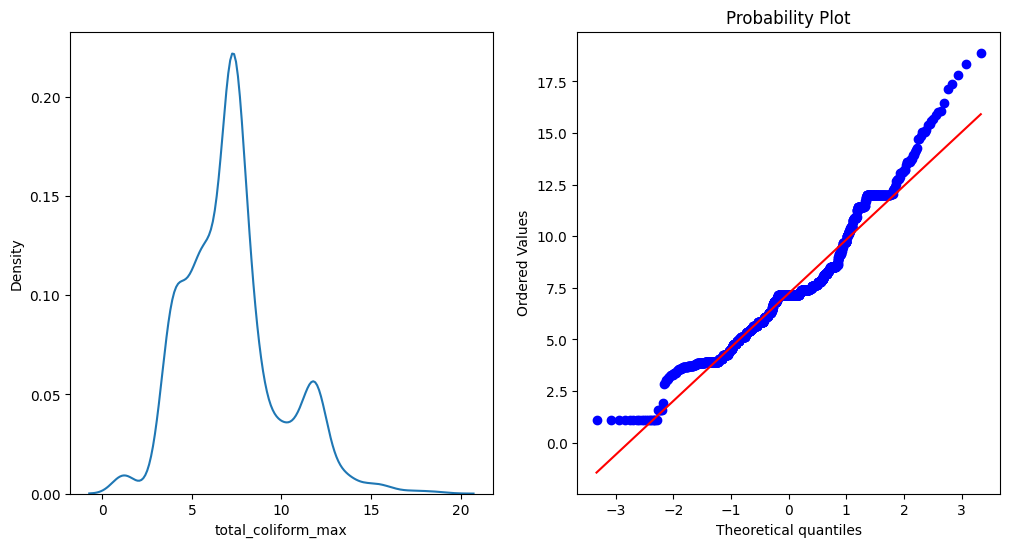

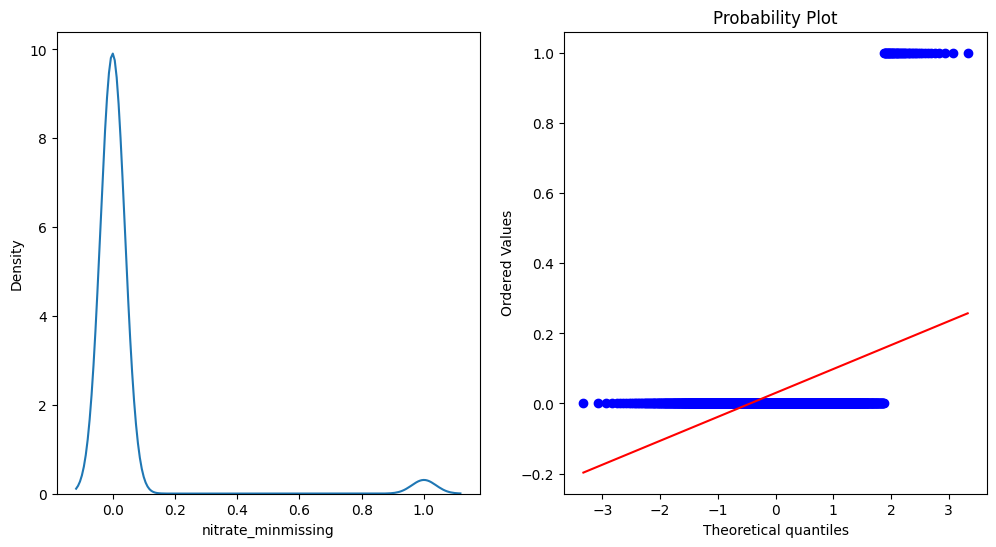

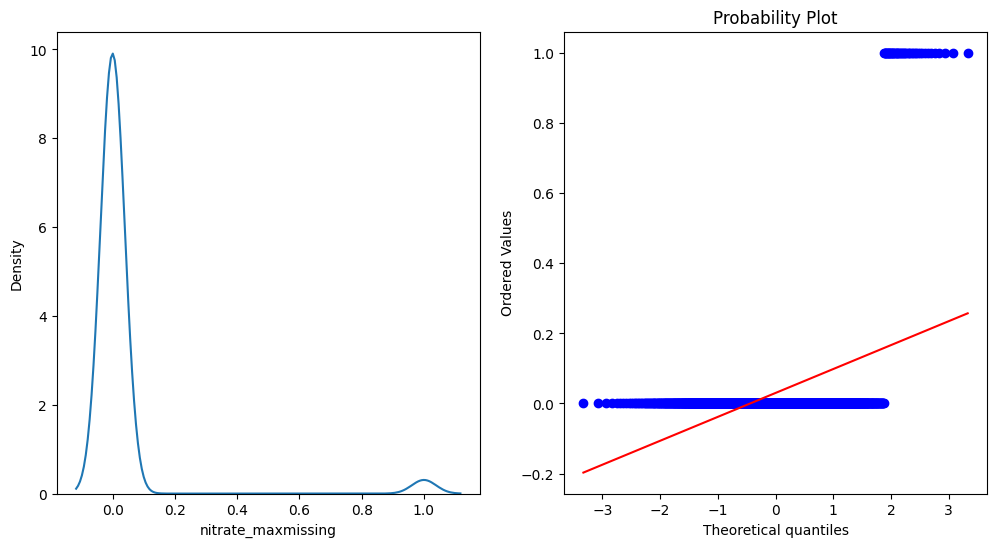

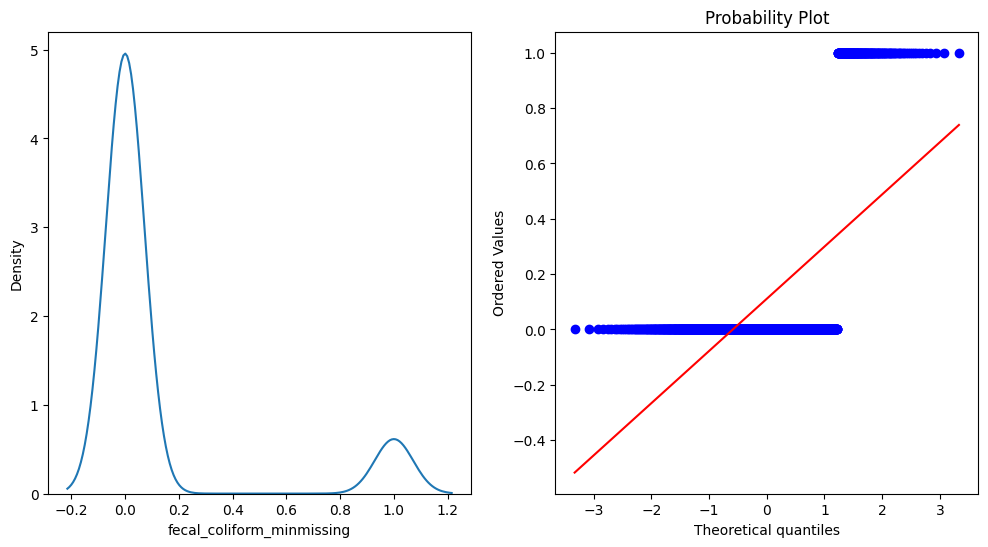

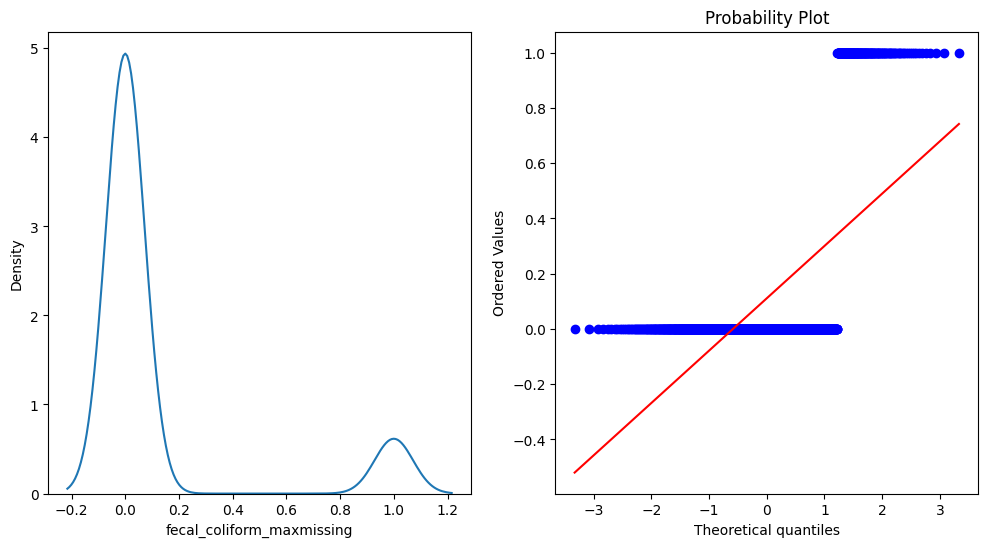

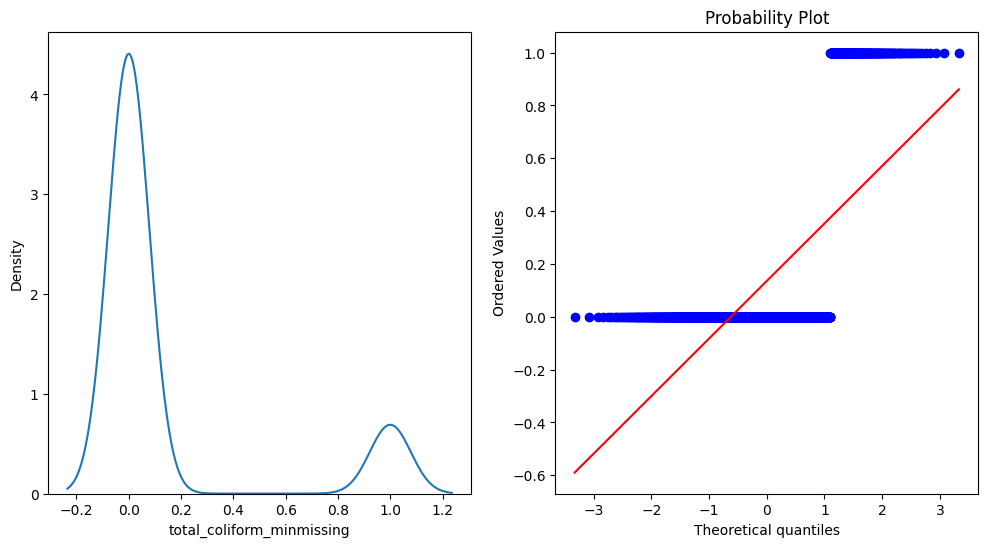

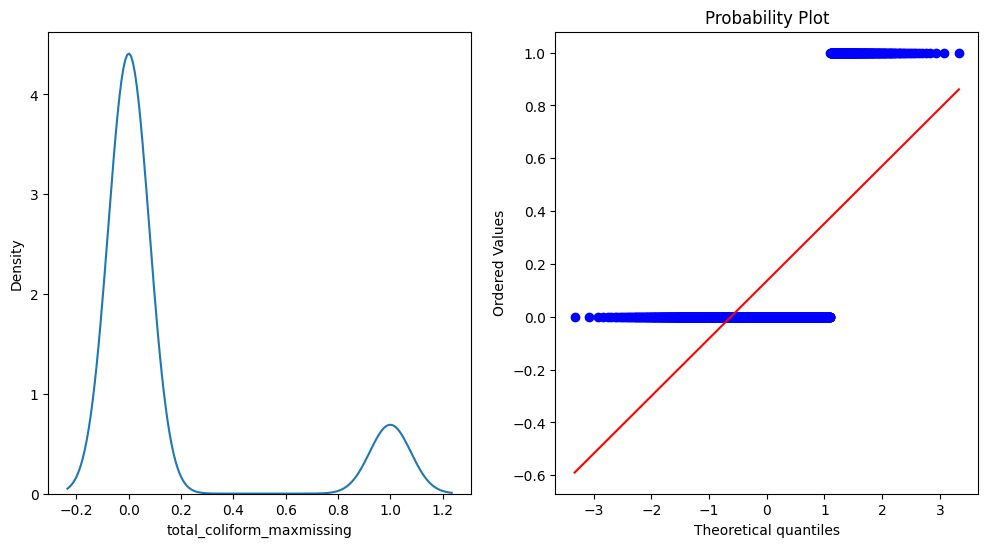

In [273]:
from scipy import stats as stats

for col in df.select_dtypes(np.number).columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    sns.kdeplot(df, x=col, ax=ax1)
    stats.probplot(df[col], dist='norm', plot=ax2)
    plt.show()

In [265]:
df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']] = df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']].apply(np.log1p)

In [272]:
df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']] = df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']].apply(np.log1p)